In [3]:
#%!install python -m pip install hmms

import numpy as np
import matplotlib.pyplot as plt
import hmms
from pprint import pformat

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Continuous Time Models for Picker Modelling

This is a first experiment to turn map topology into a CtHMM and use it for *anytime prediciton* of picker localisation in order to support scheduling in an anticipatory way, and to support robust and reliable tracking of pickers within a topological graph.

## CtHMM

### general HMM

![hmm](hmm-general.png)

### time continuous case

![hmm](hmm-discrete-continous.jpg)


## RASberry context

https://rasberryproject.com/

![thorvald](thorvald_riseholme_sim.jpg)

## Topological Map of Riseholme Farm

* There is a very strong prior on where people can move, based on topology
* Pickers are expected to move at a certain speed (with some noise added to it)
* The position tracking of pickers is extremely noisy

![rviz topology](rviz.png)


## Some resources:

* Python library used for this: https://pypi.org/project/hmms/
* https://en.wikipedia.org/wiki/Markov_chain#Continuous-time_Markov_chain
* http://u.math.biu.ac.il/~amirgi/CTMCnotes.pdf
* https://en.wikipedia.org/wiki/Transition_rate_matrix

## Assumption in this experiment

* A core assumption of CtMC (and CtHMM for that matter) is that the temporal dynamics of staying in a state transitioning into a new one is represented by an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), defined by the mean of resident time in a state. I.e., we can turn the data of resident duration in a state into an exponential model for the CtHMM 
* for simplicity, the model assumes a cyclic topology of a given size (`N_nodes`)
* assumes a topological graph that only allows to move "forward" in the topological (one-way traffic)
* assumes a *fixed rate* for travel times between nodes (mean `_rate`), this defines the `_lambda` for the expontential PDF modelling the temporal behaviour of each edge. 



In [64]:
# My experiment

N_nodes = 10

# expected mean rate in seconds
_rate = 5.0
_lambda = 1.0/_rate


# defining a very simple topological map (a circle) of N_nodes states
# we can go form 1->2, 2->3 etc only
topo_map=np.eye(N_nodes, k=1)
topo_map[-1,0] = 1

# this will add an unlikely reverse move:
topo_map+=np.eye(N_nodes, k=-1) * .1
topo_map[0,-1] = .1

# summing all column of adjency matrix
rs = np.sum(topo_map,1)

# creating the transition rate matrix (https://en.wikipedia.org/wiki/Transition_rate_matrix)
Q = (np.diag(-rs) + topo_map) * _lambda

# creating observation matrix, assuming each states has ~70% prob to emit the state itself as observation
# and another ~10% for neighbouring states each (confusing them). and +.1% for all observations
# for numerical stability
B_pre = np.ones(N_nodes) * .001 + np.eye(N_nodes) * .7 + np.eye(N_nodes, k=1) * .1 + np.eye(N_nodes, k=-1) * .1
# adding 10% change of "unknown" observation which each state is equally likely to emit (used for prediction)
B = np.transpose(np.vstack([B_pre, [.101] * N_nodes]))
B[0,-2] = .101
B[-1,0] = .101


# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]


# Pi is the vector of initial state probabilities. Assuming uniform here
# (We may make a stronger assumption here at some point)
Pi = np.array( [1.0 / N_nodes] * N_nodes )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)
print('Q=%s,\nB=%s,\nPi=%s' % chmm.params)

Q=[[-0.22  0.2   0.    0.    0.    0.    0.    0.    0.    0.02]
 [ 0.02 -0.22  0.2   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.02 -0.22  0.2   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.02 -0.22  0.2   0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.02 -0.22  0.2   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.02 -0.22  0.2   0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.02 -0.22  0.2   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.02 -0.22  0.2   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.02 -0.22  0.2 ]
 [ 0.2   0.    0.    0.    0.    0.    0.    0.    0.02 -0.22]],
B=[[0.6933729  0.09990109 0.00098912 0.00098912 0.00098912 0.00098912
  0.00098912 0.00098912 0.00098912 0.09990109 0.09990109]
 [0.09990109 0.6933729  0.09990109 0.00098912 0.00098912 0.00098912
  0.00098912 0.00098912 0.00098912 0.00098912 0.09990109]
 [0.00098912 0.09990109 0.6933729  0.09990109 0.00098912 0.00098912
  0.00098912 0.00098912 0.00098912 0.0009891

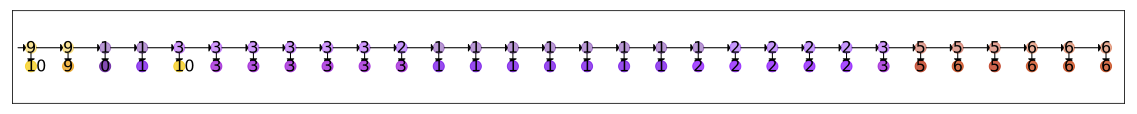

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58.]


In [66]:
# sample a random sequence from the model (for testing and generation)

# sample length (seconds)
sample_len = 60

# sample step (s)
sample_step = 2

# sample uniformly
t_seq = range(0,sample_len, sample_step)
t_seq, s_seq, e_seq = chmm.generate( len(t_seq), time=t_seq)

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
print(t_seq)



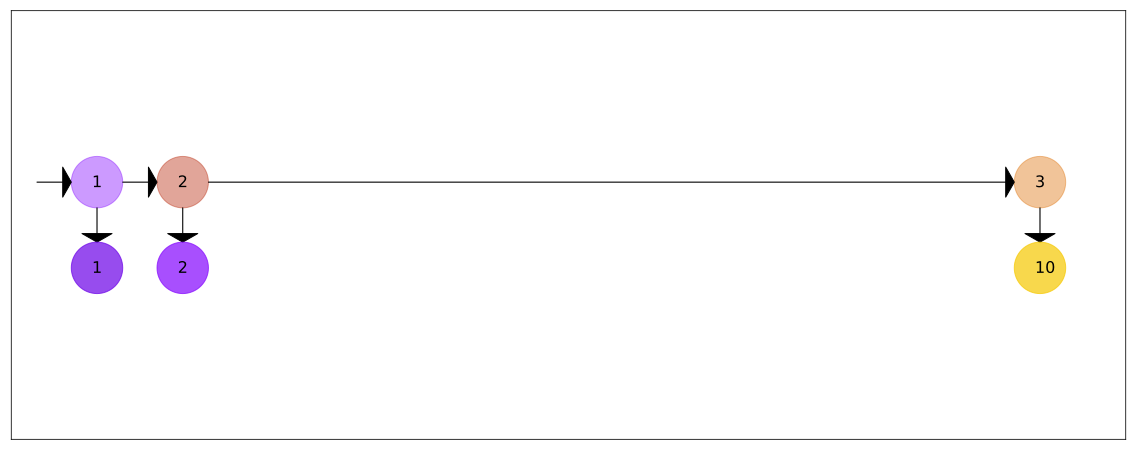

found state sequence: 
 [1 2 3]
predicted state looking 10.000000 seconds into the future: 3
Probability of being generated by the found state sequence: 0.0002077741347477643
state probs: 
 [0.01037591 0.06607723 0.1901993  0.26252734 0.226339   0.13976369
 0.06683774 0.02601455 0.0085793  0.00328593]
Kullback–Leibler divergence (high is good in this case, as I compare against uniform): 0.462208


In [68]:
# now let's try some prediction, define the predict function

def predict(obs=np.array([1,2,3]), predict_time=20.0, verbose=False):

    # observations so far (this is where we have seen people being in a place at a specific time):
    e_seq = np.array(obs)
    # assume the observations were made 1 second apart
    t_seq = np.array(range(0,len(e_seq)))

    # Now the predict step
    # the last observation codes for unknown, "abusing" the Viterbi algorithm to provide predictions 
    # purely on the transition model
    e_seq[-1:]=N_nodes 

    # this is the look ahead time (i.e. the time we look into the future based on the last observation)
    #predict_time = 1.2

    # set the last "unknown" observation time:
    t_seq[-1] = t_seq[-2] + predict_time

    #print(t_seq, e_seq)

    # run Viterbi algorithm for the CtHMM
    ( log_prob, s_seq ) =  chmm.viterbi( t_seq, e_seq )


    # We can also query the state distribution for the entire sequence
    log_prob_table = chmm.states_confidence( t_seq, e_seq )
    post_distribution = np.exp( log_prob_table[-1] )

    if verbose:
        # Let's print the most likely state sequence
        hmms.plot_hmm( s_seq, e_seq, time = t_seq )
        print( "found state sequence: \n", s_seq )
        print( "predicted state looking %f seconds into the future: %d" % (predict_time, s_seq[-1]) )
        print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )
        print( "state probs: \n", post_distribution)

    uniform = np.array([1.0 / N_nodes] * N_nodes)

    # KL divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
    # D_KL = (post_distribution || uniform)
    # KL can be used here as a measure of certainty to some extend, used to compare against uniform distribution, 
    # the longer into the future the prediction, the closer KL is to 0
    D_KL = np.sum(np.multiply(post_distribution, np.log(np.divide(post_distribution, uniform))))
    if verbose:
        print("Kullback–Leibler divergence (high is good in this case, as I compare against uniform): %f" % D_KL)

    return (s_seq[-1], D_KL, post_distribution)
    #for i in range(0,len(uniform)):


(state, KL, posteriors) = predict(
    # start with some observations assumed to have made up to a point
    obs=np.array([1,2,3]),
    # the time horizon to predict to
    predict_time=10.0,
    # we want to see stuff here
    verbose=True
)


state predictions:
{1.0: 2,
 2.0: 2,
 3.0: 2,
 4.0: 2,
 5.0: 2,
 6.0: 3,
 7.0: 3,
 8.0: 3,
 9.0: 3,
 10.0: 3,
 11.0: 4,
 12.0: 4,
 13.0: 4,
 14.0: 4,
 15.0: 4,
 16.0: 4,
 17.0: 5,
 18.0: 5,
 19.0: 5,
 20.0: 5,
 21.0: 5,
 22.0: 6,
 23.0: 6,
 24.0: 6,
 25.0: 6,
 26.0: 6,
 27.0: 6,
 28.0: 7,
 29.0: 7,
 30.0: 7,
 31.0: 7,
 32.0: 7,
 33.0: 7,
 34.0: 8,
 35.0: 8,
 36.0: 8,
 37.0: 8,
 38.0: 8,
 39.0: 9,
 40.0: 9,
 41.0: 9,
 42.0: 9,
 43.0: 9,
 44.0: 9,
 45.0: 0,
 46.0: 0,
 47.0: 0,
 48.0: 0,
 49.0: 0,
 50.0: 0,
 51.0: 1,
 52.0: 1,
 53.0: 1,
 54.0: 1,
 55.0: 1,
 56.0: 1,
 57.0: 2,
 58.0: 2,
 59.0: 2,
 60.0: 2}


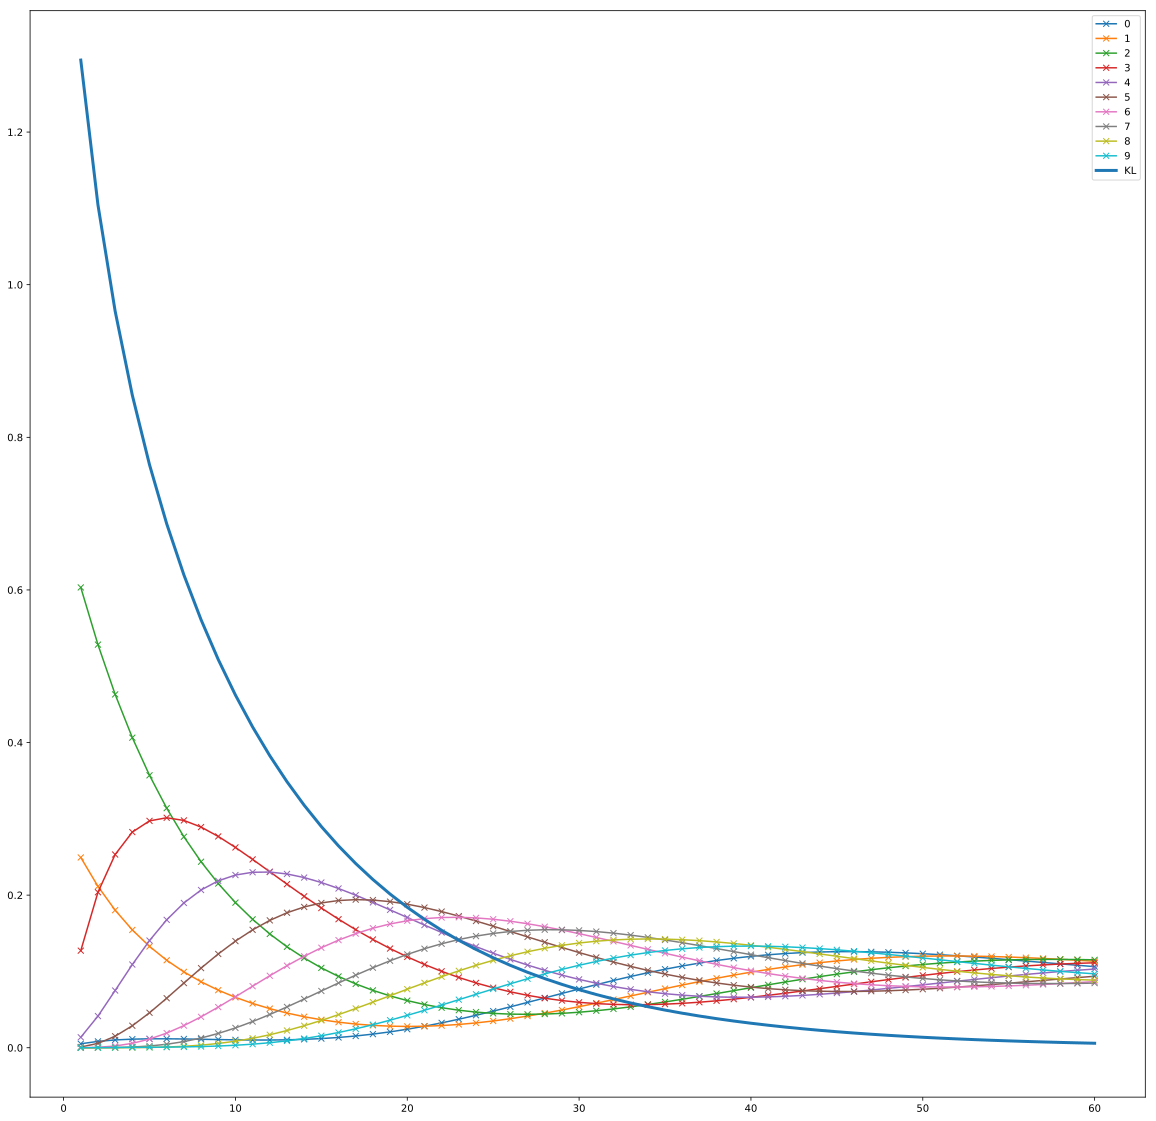

In [69]:
# now some iterations:

# forecast max seconds
forecast_max = 60
forecast_steps = 60


posteriors = []
states = {}
kls = []
times = []
bars = []

# try forecasting for several time steps:
for i in np.linspace(1, forecast_max, forecast_steps):
    (state, kl, posterior) = predict(
        obs = [1,2,3],
        predict_time = i,
        verbose = False
    )
    times.append(i)
    posteriors.append(posterior)
    states[i] = state
    kls.append(kl)

# plot the posterior probabilities
plt.plot(times, posteriors, '-x')

# plot the KL divergence (certainty)
plt.plot(times, kls, linewidth=3)

legend = list(range(0, N_nodes))
legend.append('KL')
plt.legend(legend)
print('state predictions:\n%s' % pformat(states))

# For tracking applications

* For tracking applications, we assume discrete observations (i.e. a picker is localised at a specific discrete topological node
* We have a "fake" (or _query_) observation, that is equally likely to be emmitted by any state, i.e. it doesn't actually provide any evidence to the model from observation, so we are only predicting

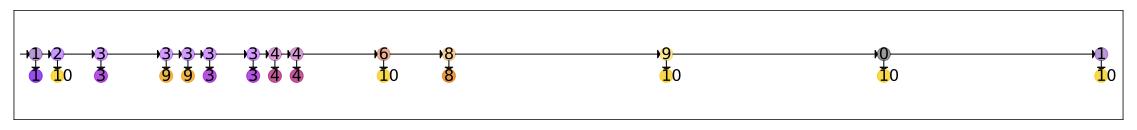

found state sequence: 
 [1 2 3 3 3 3 3 4 4 6 8 9 0 1]
Probability of being generated by the found state sequence: 2.2950092628392636e-20
state probs: 
 [[ -3.19126433  -0.38360958  -1.30402282  -5.5901091   -7.96977998
   -9.7417461   -8.79468459  -7.86420977  -7.29995214  -7.27219669]
 [ -3.54695778  -1.00591971  -0.74958183  -2.05138694  -6.80837446
  -10.08270264  -9.1267685   -8.03135799  -7.2901505   -6.16735679]
 [ -3.85417356  -4.83175902  -1.27538556  -0.38522978  -5.23037594
  -10.48834928  -9.80311215  -8.57703377  -7.33272683  -5.30997819]
 [ -3.35303558  -6.18833292  -2.05024505  -0.2640703   -3.03017555
   -7.62981304 -12.00398605 -11.51733899  -6.60813495  -4.1235161 ]
 [ -3.25340568  -6.39977672  -2.56804402  -0.20373733  -2.9050268
   -7.84741051 -13.75248397 -18.92885058 -10.13123011  -4.41003704]
 [ -7.66430491  -7.56399935  -3.20769231  -0.10327005  -2.87277851
  -11.46563338 -16.45297482 -19.72866526 -13.93847236  -8.98217936]
 [-16.74387103 -14.73689465  -6.2061743

In [70]:
# observations so far (this is where we have seen people being in a place at a specific time):
t_seq = np.array([1,2,4,7,8,9,11,12,13,17,20,30,40,50])
e_seq = np.array([1,N_nodes,3,9,9,3,3,4,4,N_nodes, 8,N_nodes,N_nodes,N_nodes])

( log_prob, s_seq ) =  chmm.viterbi( t_seq, e_seq )

# We can also query the state distribution for the entire sequence
log_prob_table = chmm.states_confidence( t_seq, e_seq )

# Let's print the most likely state sequence
hmms.plot_hmm( s_seq, e_seq, time = t_seq )
print( "found state sequence: \n", s_seq )
print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )
print( "state probs: \n", log_prob_table)




Initial probabilities (π) :


,0
0,0.011408
1,0.159066
2,0.157284
3,0.062841
4,0.009872
5,0.158676
6,0.016285
7,0.054200
8,0.111298
9,0.259070


Transition rate matrix (Q):


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,0.159919,0.003312,0.021423,0.206579,0.082008,0.185277,0.113274,0.199874,0.028335
1,0.174888,-1.000000,0.187243,0.203278,0.049151,0.036744,0.031751,0.014549,0.227992,0.074405
2,0.035750,0.067881,-1.000000,0.110017,0.106472,0.096915,0.277378,0.075374,0.125881,0.104332
3,0.122458,0.151651,0.017238,-1.000000,0.042278,0.069043,0.185549,0.179682,0.075379,0.156723
4,0.060338,0.239627,0.015693,0.181983,-1.000000,0.059285,0.169387,0.042990,0.148035,0.082661
5,0.075128,0.000290,0.004362,0.263105,0.217241,-1.000000,0.154452,0.093266,0.107991,0.084165
6,0.015893,0.102467,0.051457,0.146581,0.505378,0.029899,-1.000000,0.095597,0.042046,0.010682
7,0.053041,0.000007,0.043373,0.194137,0.007977,0.107087,0.321798,-1.000000,0.223336,0.049243
8,0.222573,0.085345,0.148197,0.019163,0.057238,0.345944,0.048984,0.025883,-1.000000,0.046674
9,0.129427,0.011456,0.258665,0.164435,0.007539,0.266720,0.098442,0.051520,0.011796,-1.000000


Transition probabilities for one time unit :


,0,1,2,3,4,5,6,7,8,9
0,0.394676,0.083069,0.021941,0.045220,0.110876,0.059297,0.098943,0.056604,0.102957,0.026418
1,0.089372,0.394301,0.085396,0.098263,0.048874,0.048953,0.051669,0.027353,0.109701,0.046118
2,0.036508,0.049283,0.387450,0.075547,0.083066,0.063068,0.132510,0.047214,0.071630,0.053724
3,0.067643,0.074576,0.029155,0.405341,0.053956,0.054222,0.102927,0.082165,0.059298,0.070717
4,0.050766,0.108604,0.029507,0.098476,0.404085,0.050486,0.091595,0.035410,0.083193,0.047877
5,0.051011,0.031042,0.017981,0.125617,0.111680,0.396428,0.094017,0.056047,0.066646,0.049530
6,0.029678,0.072413,0.033373,0.090730,0.202994,0.034166,0.409066,0.052144,0.050357,0.025080
7,0.043691,0.025609,0.033001,0.100071,0.053434,0.069212,0.147026,0.390716,0.102629,0.034612
8,0.100378,0.052129,0.066447,0.046144,0.062383,0.146487,0.058858,0.030721,0.401674,0.034779
9,0.065658,0.026226,0.103767,0.094642,0.045139,0.117754,0.080798,0.042851,0.034728,0.388438


Emission probabilities matrix (B):


,0,1,2,3,4,5,6,7,8,9,10
0,0.050448,0.044187,0.087634,0.078928,0.104026,0.140422,0.124835,0.020171,0.070746,0.132889,0.145714
1,0.175563,0.083309,0.022293,0.109284,0.003054,0.210361,0.003366,0.173732,0.124220,0.091275,0.003543
2,0.083907,0.072812,0.021169,0.099191,0.052004,0.162236,0.128417,0.058349,0.085603,0.209091,0.027223
3,0.109156,0.140960,0.000245,0.122952,0.002263,0.244283,0.091347,0.016465,0.055538,0.021295,0.195496
4,0.227035,0.427011,0.000488,0.019620,0.048538,0.065445,0.020007,0.110016,0.000148,0.017659,0.064033
5,0.022819,0.103587,0.304076,0.117767,0.013136,0.202395,0.003413,0.036037,0.180017,0.011813,0.004939
6,0.099217,0.065174,0.193161,0.095180,0.247052,0.137504,0.013335,0.047383,0.043031,0.046158,0.012806
7,0.239373,0.085614,0.110693,0.014426,0.002759,0.165591,0.177048,0.026925,0.085039,0.089990,0.002543
8,0.182635,0.062159,0.037396,0.006772,0.044830,0.049835,0.031474,0.005218,0.097015,0.221112,0.261554
9,0.166524,0.013858,0.127771,0.085218,0.234983,0.002788,0.010315,0.093764,0.059945,0.186959,0.017874


iteration  1990641219 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30
iteration  10 / 30


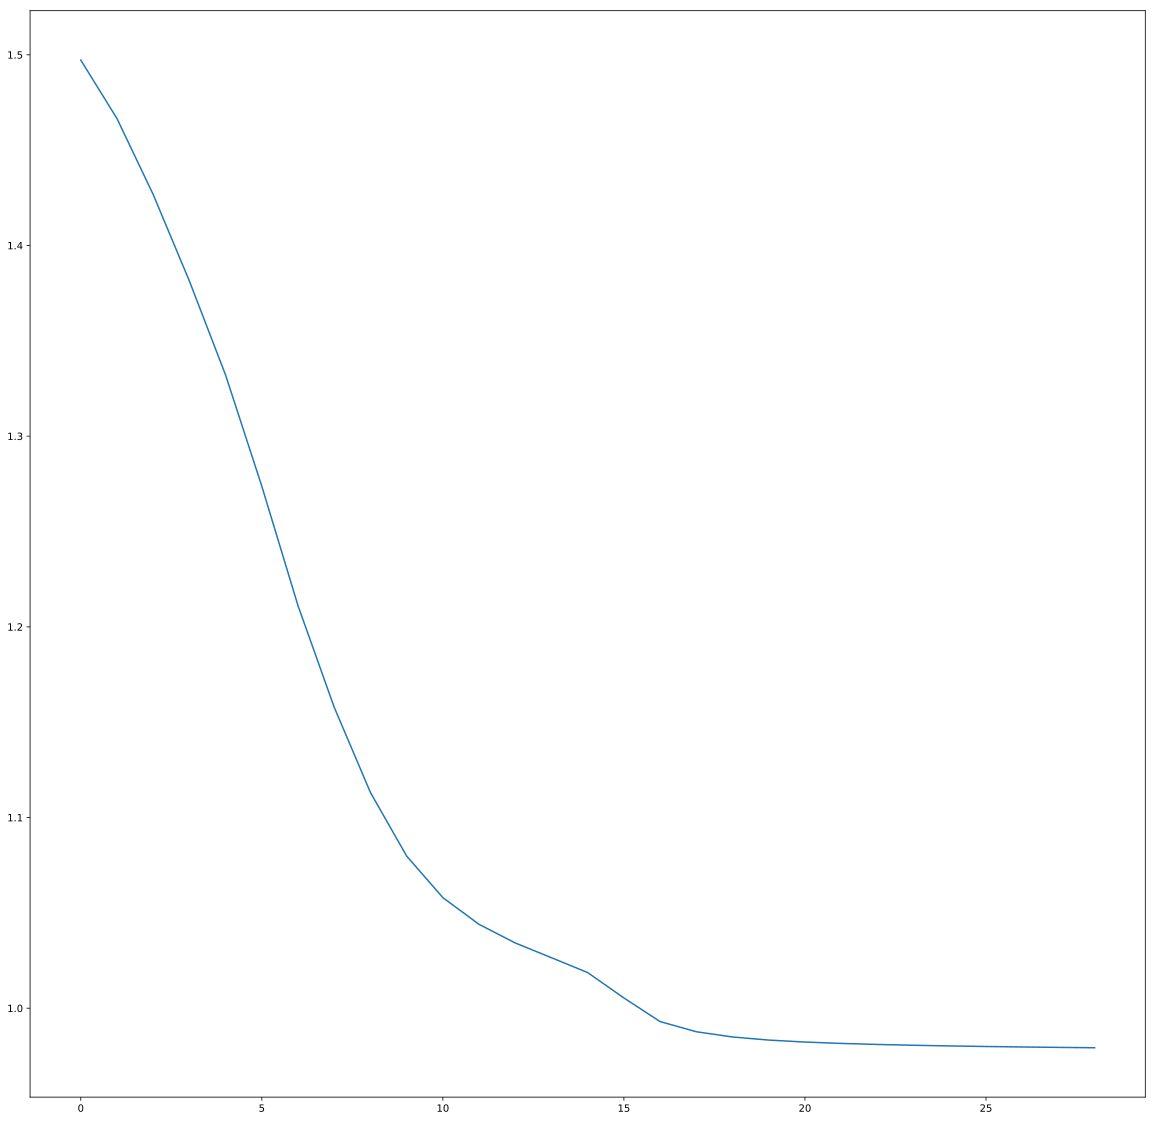

In [11]:
# we can even learn paramters:

seq_num= 25   #number of data sequences
seq_len= 20  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )
t,e

chmm_r = hmms.CtHMM.random( N_nodes, N_nodes+1 )
# We can print all the parameters.
hmms.print_parameters( chmm_r )
out = chmm_r.baum_welch( t,e, 30, est=True )

np.exp(out)

real = chmm.data_estimate( t, e )
#For better visibility of the graph, we cut first two values.
plt.plot( out[2:] / real  )

plt.show()

In [213]:
hmms.print_parameters( chmm_r )
print(t,e)

Initial probabilities (π) :


,0
0,1.141494e-01
1,1.645993e-01
2,4.022324e-02
3,1.426127e-01
4,2.277982e-01
5,2.467288e-27
6,1.140550e-01
7,2.233887e-08
8,1.965482e-01
9,1.388290e-05


Transition rate matrix (Q):


,0,1,2,3,4,5,6,7,8,9
0,-8.888091e-02,8.887989e-02,2.411308e-14,2.001114e-19,8.187432e-20,6.333790e-07,3.829101e-07,4.644782e-15,9.912680e-10,1.770705e-14
1,6.267685e-11,-1.033092e-01,2.116374e-20,8.420477e-16,1.075932e-09,4.586930e-04,1.028505e-01,3.106807e-19,2.660916e-20,1.765768e-20
2,2.409410e-05,1.457779e-24,-3.745566e-01,5.340998e-02,2.628605e-03,1.836778e-12,1.187798e-19,4.255508e-03,1.974492e-01,1.167892e-01
3,2.758646e-10,4.664671e-23,4.282142e-02,-2.730353e-01,1.884405e-03,2.756242e-10,4.961728e-15,2.046463e-01,7.065536e-05,2.361247e-02
4,4.573535e-31,2.926491e-22,6.891227e-06,1.792185e-01,-1.818604e-01,2.496650e-05,4.485547e-09,2.583905e-03,2.645858e-09,2.618042e-05
5,6.549888e-27,1.594276e-11,4.324415e-08,9.531525e-07,1.864931e-01,-2.469723e-01,6.047280e-02,5.228899e-06,2.089473e-12,1.505321e-07
6,1.955956e-20,2.670948e-06,5.684867e-08,1.176120e-08,3.211894e-06,3.024385e-01,-3.024456e-01,1.162113e-06,1.356416e-12,2.645277e-08
7,4.545013e-07,4.541773e-23,4.153269e-01,1.641764e-01,9.828981e-03,2.291669e-10,7.032086e-17,-6.986267e-01,1.440256e-03,1.078538e-01
8,1.501541e-01,4.929763e-11,1.267292e-03,3.790284e-06,3.183537e-09,4.897532e-19,6.065448e-23,7.316597e-05,-1.529594e-01,1.461109e-03
9,4.680227e-05,3.869287e-23,2.247372e-01,6.890311e-03,9.555250e-05,1.513351e-13,8.248069e-19,9.409781e-02,6.141853e-02,-3.872862e-01


Transition probabilities for one time unit :


,0,1,2,3,4,5,6,7,8,9
0,9.149545e-01,8.073721e-02,7.163092e-09,6.831600e-07,0.000019,4.016948e-04,3.886811e-03,3.307772e-08,1.131394e-09,3.471478e-09
1,4.842353e-10,9.018482e-01,4.714057e-07,3.691557e-05,0.000822,1.292804e-02,8.436223e-02,1.970252e-06,1.908203e-08,2.258062e-07
2,1.228602e-02,3.720712e-04,6.991298e-01,3.995588e-02,0.002085,6.301166e-07,9.328618e-06,9.519046e-03,1.554488e-01,8.119324e-02
3,3.018225e-04,6.500469e-06,6.126877e-02,7.739664e-01,0.002276,3.226162e-08,1.273815e-07,1.287519e-01,6.288022e-03,2.713990e-02
4,1.414396e-05,2.485467e-07,5.195077e-03,1.437640e-01,0.833913,2.021376e-05,6.003404e-07,1.436097e-02,3.811984e-04,2.350085e-03
5,5.123782e-07,7.271390e-08,2.982319e-04,1.329631e-02,0.150986,7.881881e-01,4.609295e-02,9.825396e-04,1.701467e-05,1.384030e-04
6,2.585502e-08,2.190868e-06,2.135328e-05,1.315568e-03,0.022144,2.305215e-01,7.459040e-01,8.015258e-05,1.007708e-06,1.008586e-05
7,1.739627e-03,4.082256e-05,2.570877e-01,1.108265e-01,0.006938,1.371760e-07,8.487192e-07,5.113343e-01,3.183842e-02,8.019393e-02
8,1.330825e-01,5.948372e-03,1.119247e-03,4.269343e-05,0.000003,1.540435e-05,1.949243e-04,1.005758e-04,8.583111e-01,1.182664e-03
9,4.701600e-03,1.364394e-04,1.670324e-01,1.453850e-02,0.000622,2.187682e-07,3.338808e-06,5.663001e-02,6.462727e-02,6.917083e-01


Emission probabilities matrix (B):


,0,1,2,3,4,5,6,7,8,9,10
0,3.216464e-26,1.350180e-08,3.494197e-01,4.865081e-01,6.922223e-02,1.264209e-22,1.798254e-09,4.138899e-56,1.039737e-31,4.953685e-46,0.094850
1,7.935320e-41,4.588648e-21,1.719473e-11,1.344996e-02,3.565914e-01,4.510222e-01,6.545377e-02,9.453765e-22,3.245774e-15,3.510791e-24,0.113483
2,8.519584e-01,9.885826e-02,5.088973e-15,5.919910e-42,3.023956e-66,1.750423e-54,4.138748e-33,2.313129e-41,1.511976e-12,4.327014e-02,0.005913
3,5.064010e-02,5.170153e-13,6.303470e-30,1.824948e-54,1.424229e-79,1.016483e-53,5.639849e-29,4.087103e-19,3.555611e-02,9.117267e-01,0.002077
4,1.655512e-02,1.164944e-40,3.280335e-72,6.386060e-71,1.550182e-69,1.357895e-43,2.814657e-18,4.620903e-02,5.899571e-01,2.529033e-01,0.094375
5,5.779703e-61,2.676568e-70,3.206788e-60,3.299449e-50,5.041931e-44,5.025310e-17,7.977154e-04,7.934348e-01,2.035986e-01,8.878054e-12,0.002169
6,7.285031e-21,1.710642e-56,1.085309e-46,1.552595e-37,1.264283e-26,1.645201e-05,6.410440e-01,1.989278e-01,5.146022e-04,1.065457e-18,0.159497
7,4.208487e-01,2.502762e-06,1.277570e-24,4.616447e-55,3.685200e-79,2.146735e-52,5.479806e-20,7.921590e-25,1.511713e-09,1.803177e-01,0.398831
8,1.221100e-01,6.151769e-01,1.436154e-01,2.532793e-24,9.138053e-39,1.836869e-42,3.077805e-49,5.018825e-53,1.602106e-20,1.203496e-13,0.119098
9,6.916104e-01,2.179953e-03,2.267028e-15,6.672556e-43,4.907352e-66,1.540118e-54,4.771067e-29,1.481685e-37,1.122785e-11,1.062641e-01,0.199946


[[ 0  1  2  4  5  6  8  9 10 12 18 22 24 27 29 31 35 39 40 43]
 [ 0  1  2  3  6 10 12 13 15 16 18 19 25 26 32 37 38 39 41 42]
 [ 0  2  6  9 10 15 16 17 21 23 25 26 30 31 33 35 39 41 42 43]
 [ 0  1  5 11 17 20 21 24 25 31 35 36 38 40 41 44 45 47 50 51]
 [ 0  1  2  4  8 11 13 18 24 28 29 32 33 34 40 44 46 48 51 53]
 [ 0  2  3  5  6  9 16 17 19 24 25 26 29 36 39 41 42 45 51 54]
 [ 0  2  4  6 10 14 20 21 23 27 28 30 31 32 33 34 35 37 39 40]
 [ 0  1  2  3 12 14 23 26 30 32 34 36 41 42 44 49 52 54 55 58]
 [ 0  2  5 11 14 17 18 19 20 24 29 30 31 35 37 40 41 42 43 47]
 [ 0  4  6  8  9 12 13 15 16 21 22 27 29 31 35 36 37 55 59 60]
 [ 0  1  4  7 15 19 20 24 25 28 30 34 36 39 42 43 51 54 55 56]
 [ 0  2  3  8  9 18 20 21 22 23 28 35 39 40 43 44 45 48 49 51]
 [ 0  3  6  7 10 11 14 17 21 24 27 32 36 38 39 43 46 48 51 53]
 [ 0  1  2  3  4  6  7  9 15 17 20 21 22 23 24 25 28 33 35 36]
 [ 0  3  7  8  9 12 13 15 17 20 28 29 32 33 35 36 38 39 40 41]
 [ 0  1  3  5  6  8 10 11 14 15 20 21 26 27 34 37 38 40

In [51]:
seq_num = 25
seq_len = 50

#generate artificial dataset of times, hidden states and emissions sequences
t_seqs, s_seqs, e_seqs = chmm.generate_data( (seq_num,seq_len), states=True )

chmm_ml = hmms.CtHMM.random(N_nodes,N_nodes+1) 
graph = chmm_ml.maximum_likelihood_estimation(s_seqs,t_seqs,e_seqs,30,est=True )

it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
it 10
it 11
it 12
it 13
it 14
it 15
it 16
it 17
it 18
it 19
it 20
it 21
it 22
it 23
it 24
it 25
it 26
it 27
it 28
it 29


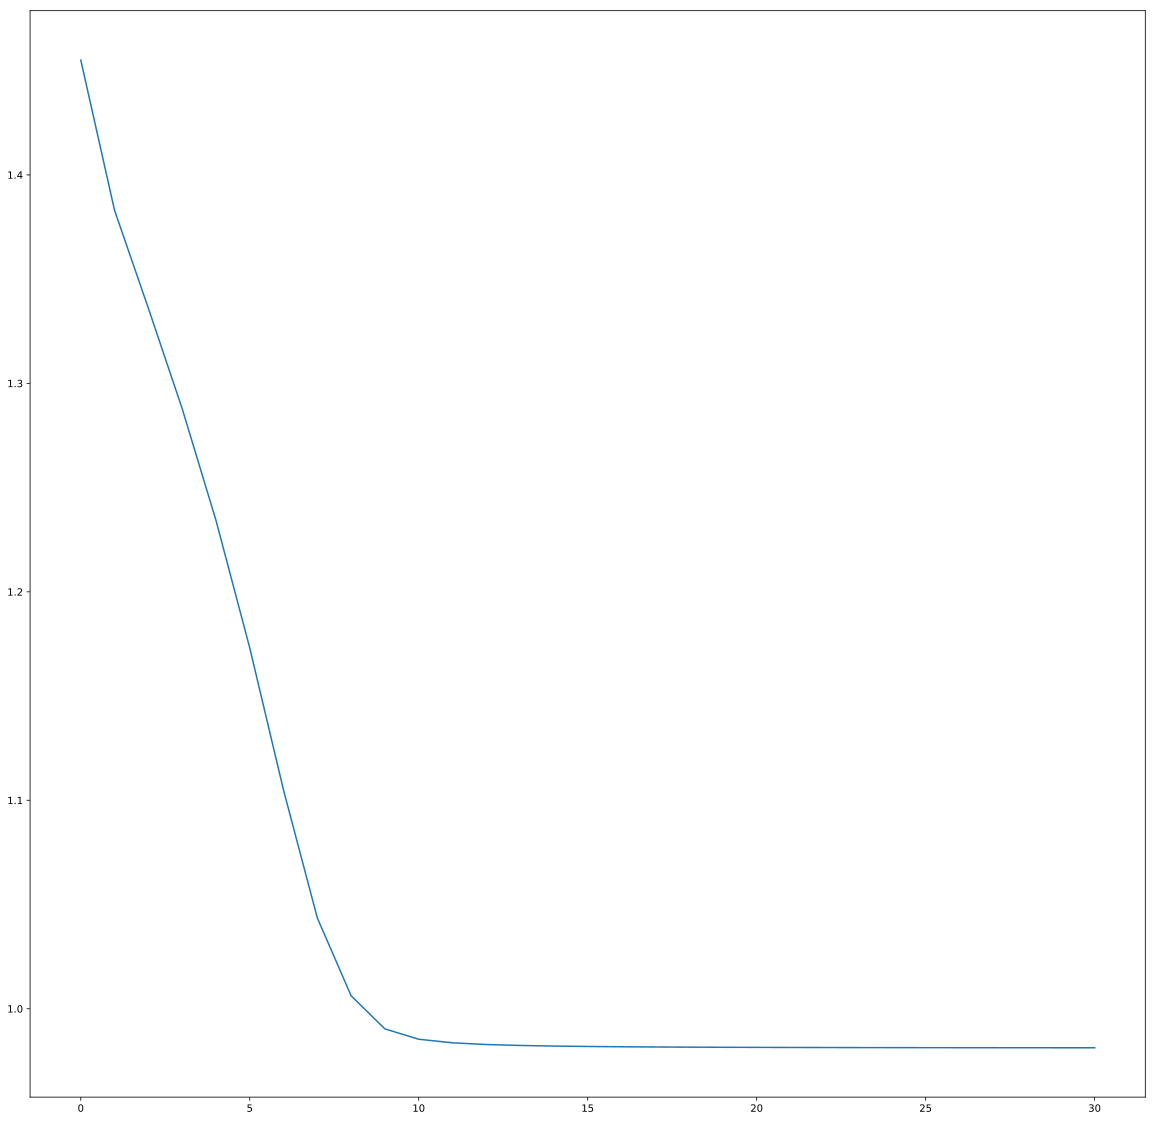

Initial probabilities (π) :


,0
0,0.08
1,0.04
2,0.16
3,0.08
4,0.04
5,0.08
6,0.04
7,0.32
8,0.08
9,0.08


Transition rate matrix (Q):


,0,1,2,3,4,5,6,7,8,9
0,-1.976376e-01,1.912388e-01,1.094246e-07,2.191707e-15,4.044959e-15,5.719913e-27,4.048243e-31,2.051958e-23,1.154748e-15,6.398731e-03
1,1.551880e-02,-2.648162e-01,2.460860e-01,3.211387e-03,2.678445e-13,4.720736e-19,3.113893e-33,2.711213e-31,3.490946e-24,3.223739e-13
2,1.737012e-11,1.895232e-02,-2.337978e-01,2.147634e-01,7.468683e-07,8.131656e-05,4.832180e-17,4.736584e-37,4.294172e-35,4.102829e-22
3,3.299962e-24,1.464464e-09,6.068669e-03,-2.070354e-01,2.002028e-01,7.638991e-04,2.191968e-16,2.491088e-41,3.454891e-45,2.383816e-34
4,9.128421e-39,1.939235e-22,3.542731e-14,2.437129e-02,-2.406892e-01,2.159963e-01,3.216312e-04,1.628039e-20,3.873958e-36,5.061948e-47
5,1.894044e-44,7.385411e-31,9.390040e-22,2.773212e-10,4.087793e-02,-2.443449e-01,1.990623e-01,4.404634e-03,8.430993e-13,3.423026e-38
6,3.997941e-43,1.717202e-40,3.082711e-31,4.916008e-20,9.751177e-11,6.851132e-03,-2.058470e-01,1.989779e-01,1.790807e-05,2.500603e-10
7,1.350047e-19,3.617354e-35,1.073771e-35,3.878863e-26,6.347853e-17,1.733215e-11,1.199803e-02,-2.248449e-01,2.127355e-01,1.113188e-04
8,7.040121e-04,6.984302e-15,2.815242e-21,1.767613e-19,4.063830e-23,9.850571e-18,1.491532e-08,1.492969e-02,-2.008049e-01,1.851712e-01
9,1.529379e-01,1.454907e-02,1.084082e-08,4.385931e-11,3.693450e-11,1.609414e-21,5.878494e-19,1.631698e-10,1.957148e-02,-1.870584e-01


Transition probabilities for one time unit :


,0,1,2,3,4,5,6,7,8,9
0,8.222625e-01,1.520427e-01,1.867774e-02,1.591278e-03,8.348819e-05,4.594476e-06,1.764674e-07,2.639613e-07,5.156068e-05,5.285716e-03
1,1.233504e-02,7.703221e-01,1.920875e-01,2.345463e-02,1.647815e-03,1.074620e-04,4.915258e-06,2.882740e-07,2.724849e-07,4.003171e-05
2,1.167072e-04,1.479303e-02,7.938710e-01,1.726186e-01,1.716214e-02,1.359076e-03,7.415161e-05,4.777317e-06,1.978822e-07,2.578551e-07
3,2.415282e-07,4.551120e-05,4.877084e-03,8.154803e-01,1.604658e-01,1.780272e-02,1.234522e-03,8.943870e-05,4.197652e-06,1.446175e-07
4,1.157874e-07,3.820710e-07,5.902081e-05,1.953247e-02,7.914983e-01,1.699177e-01,1.736168e-02,1.537106e-03,8.953985e-05,3.653334e-06
5,2.834332e-06,3.412440e-07,8.145790e-07,3.960574e-04,3.215585e-02,7.872255e-01,1.593072e-01,1.932841e-02,1.506152e-03,7.684618e-05
6,4.537112e-05,5.638655e-06,2.660555e-07,9.223816e-07,1.113923e-04,5.481973e-03,8.154723e-01,1.606283e-01,1.717821e-02,1.075682e-03
7,8.886789e-04,1.204335e-04,6.924001e-06,3.785686e-07,4.585507e-07,3.286325e-05,9.684878e-03,8.008796e-01,1.722231e-01,1.616275e-02
8,1.224324e-02,1.869669e-03,1.377694e-04,8.742967e-06,3.498010e-07,1.810509e-07,7.264005e-05,1.208647e-02,8.208519e-01,1.527290e-01
9,1.264321e-01,2.342448e-02,2.388909e-03,1.858830e-04,9.063506e-06,4.820777e-07,4.942641e-07,1.192150e-04,1.614227e-02,8.312971e-01


Emission probabilities matrix (B):


,0,1,2,3,4,5,6,7,8,9,10
0,0.621622,0.189189,0.000000,0.009009,0.000000,0.000000,0.000000,0.000000,0.000000,0.099099,0.081081
1,0.066038,0.688679,0.103774,0.000000,0.000000,0.009434,0.000000,0.000000,0.000000,0.000000,0.132075
2,0.000000,0.087719,0.719298,0.070175,0.000000,0.000000,0.000000,0.000000,0.008772,0.000000,0.114035
3,0.000000,0.000000,0.119403,0.649254,0.119403,0.000000,0.000000,0.000000,0.000000,0.000000,0.111940
4,0.000000,0.000000,0.000000,0.085271,0.658915,0.155039,0.000000,0.007752,0.000000,0.000000,0.093023
5,0.000000,0.000000,0.000000,0.000000,0.085470,0.769231,0.094017,0.000000,0.000000,0.000000,0.051282
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.078261,0.695652,0.121739,0.000000,0.000000,0.104348
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092308,0.753846,0.069231,0.000000,0.084615
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077922,0.746753,0.090909,0.084416
9,0.092857,0.000000,0.000000,0.000000,0.000000,0.007143,0.007143,0.000000,0.064286,0.742857,0.085714


In [52]:
#print the convergence graph
log_est =  chmm.full_data_estimate  ( s_seqs,t_seqs,e_seqs )

plt.plot( graph / log_est )
plt.show()
hmms.print_parameters( chmm_ml )


----
# BELOW THE ORIGINAL HMMS TUTORIAL (FOR REFERENCE ONLY)
----


HMMs Library 
============================
#### (Discrete & Continuous hidden markov models )

The document contain the tutorial ( usage explained by example ) for the hidden markov models library [link to pip].
* [The **first** part](#dthmm) will cover disrete-time hidden markov model (**DtHMM**)
* [The **second** part](#cthmm) will be dedicated to continuous-time hidden markov model (**CtHMM**)
* [The **third** part](#conv) will compare the convergences of **both** models
* [The **fourth** part](#dataset) will explain how to use more complex **datasets** and run **multiple trains** by one function call

The all of the part are independent, so you do not need to run all notebook, if you are interested only in one of them. 


If you are not familiar with the hidden markov model theory, We recommend ...
%todo: refer to DP theory, (simple guide to cthmm?), github, sources


<a id='dthmm'></a>
Part 1: Discrete Time Hidden Markov Model
---------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Construct DtHMM 
You can directly initialize the DtHMM by passing the **model parameters**.  

We will create simple DtHMM of two hidden states and three output variables.

In [ ]:
# A is the matrix of transition probabilities from state [row] to state [column].
A = np.array([[0.9,0.1],[0.4,0.6]])
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array([[0.9,0.08,0.02],[0.2,0.5,0.3]])
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.8,0.2] )

# Create DtHMM by given parameters.
dhmm = hmms.DtHMM(A,B,Pi)

Or you can initialize it by **random parameters**. Passing the number of hidden states and output variables. 

In [ ]:
dhmm_random = hmms.DtHMM.random(2,3)

### Save & Read from File
Once you have created the model you can **save** its parameters in file simply by calling *save_params* method.  

In [ ]:
dhmm.save_params("hello_dthmm") 

The method stored the parameters in *.npz* format.  

The saved file can be later used to **read** parametrs for model initialization.

In [ ]:
dhmm_from_file = hmms.DtHMM.from_file( "hello_dthmm.npz" )

### Set & Get Parameters
Later you can always **set** parameters with triple of methods corresponding to the constructors.

In [ ]:
dhmm.set_params(A,B,Pi)
dhmm.set_params_random(2,3)
dhmm.set_params_from_file( "hello_dthmm.npz" )

You can **get** parameters by calling them separately,

In [ ]:
dhmm.a, dhmm.b, dhmm.pi

or **get** them **all** together as the triple.

In [ ]:
(A,B,Pi) = dhmm.params

### Generate Random State and Emission Sequence
 Now we can use our model to generate state and emission sequence.   
 The model will randomly choose which transition or emission will happen, taking into consideration the parameters we have previously defined.


In [ ]:
seq_len = 20
s_seq, e_seq = dhmm.generate( seq_len )

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq )

### Find Most Likely State Sequence
If we have the model parameters and emission sequence, we can find the most probable state sequence that would generate it. Notice, that it can be different, than the actual sequence that has generated the emissions.  
We will use Viterbi algorithm for the calculation.


In [ ]:
( log_prob, s_seq ) =  dhmm.viterbi( e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
hmms.plot_hmm( s_seq, e_seq )

The *log_prob* parameter store the probability of the sequence.  
All the probabilities in the library are stored in the logarithm of their actual value. As the number of possible sequences grows exponentialy by it length, it could easily lead to float underflow.  
You can easily transform it to the normal scale value applying *exp* function. 

In [ ]:
np.exp( log_prob )

### State Confidence 

We may want to know what is the probability that the emission was generated by some concrete state. You can get the result for every state in every time by calling the method *states_confidence*. **Notice** that the viterbi most probable sequence,  presented above, doesn't neccessery contain the most probable states from this method as here is not important the consecutive states transition probability. 

In [ ]:
log_prob_table = dhmm.states_confidence( e_seq )
np.exp( log_prob_table )

<a id='dtest'></a>
### The Probability of the Emission Sequence

We can compute the probability, that the model will generate the emission sequence.

In [ ]:
np.exp( dhmm.emission_estimate( e_seq ) )

### The Probability of the State and Emission Sequences 

Similary we can compute the probabilty of the state and emission sequences given the model parameters.

In [ ]:
np.exp( dhmm.estimate( s_seq, e_seq ) )

**Notice!**  - You can simply count the probability estimations for whole dataset by one command, watch [The chapter 4](#dsest).

### Generate Artificial Dataset

You can easily generate many sequences in once by using the generate_data function.
The generated emission sequences are in the form that is suitable for training of parameters. You can switch times=True, if you want to generate also the corresponding equidistant time sequences.

In [ ]:
seq_num= 3   #number of data sequences
seq_len= 10  #length of each sequence

dhmm.generate_data( (seq_num,seq_len) )

### Parameters Estimation - Baum Welch Algorithm
We usually do not know the real parameters of the model. But, if we have sufficient data, we can estimate them by EM algorithm.  
Here we will have several output variables (emissions) sequences and we will show, how to use them to train the model parameters

Let's start by creating some artifficial data. We will use the previously defined *dhmm* model for it.

**Notice!**  - For more detail information about possible datasets watch  [The chapter 4](#datasets).


In [ ]:
seq_num = 5
seq_len = 50

_ , data = dhmm.generate_data( (seq_num,seq_len) )

data

Now, we will create the model with random parameters, that will be eventually trained to match the data.

In [ ]:
dhmm_r = hmms.DtHMM.random( 2,3 )
# We can print all the parameters.
hmms.print_parameters( dhmm_r )

Let's compare the dataset likelihood estimation of model used for generating the data and the random parameters model. 

In [ ]:
print( "Generator model:" , np.exp( dhmm.data_estimate(data)   ) )
print( "Random model:   " ,np.exp( dhmm_r.data_estimate(data) ) )

Most likely the probability that the data was generated by random model is extremly low.

Now we can take the random model and reestimate it to fit the data better.

In [ ]:
dhmm_r.baum_welch( data, 10 )
print( "Reestimated model after 10 iterations:   " ,np.exp( dhmm_r.data_estimate(data) ) )

The probability of the reestimated model should now be similiar (possibly even higher) that the generator's model. If it is not, you can try to run the estimation procedure more time at different randomly generated models. It could happen that the estimation fall in the local optima.

If you are satisfied with the results, you can run some more iteration to fine-tune it.

In [ ]:
dhmm_r.baum_welch( data, 100 )
print( "Reestimated model after 110 iterations:   " ,np.exp( dhmm_r.data_estimate(data) ) )

We can compare the parameters of the model.

In [ ]:
hmms.print_parameters( dhmm_r )
hmms.print_parameters( dhmm )

Alternatively, we can run *baum_welch_graph* method to get learning curve of estimated probabilities.

In [ ]:
dhmm_r = hmms.DtHMM.random(2,3) 
out = dhmm_r.baum_welch( data, 50, est=True )

np.exp(out)

Let's plot it in the graph, comparing the results in ratio with *real* data-generator model. ( Notice, it is the ratio of logaritmic probability values. )

In [ ]:
real = dhmm.data_estimate(data)
#For better visibility of the graph, we cut first two values.
plt.plot( out[2:] / real  )
plt.show()

### Maximum Likelihood Estimation

Sometimes, we can have a dataset of full observations (i.e. both emission and hidden states sequences). We can use method *maximum_likelihood estimation* to estimate most likely parameters. 

In [ ]:
seq_num = 5
seq_len = 50

#generate artificial dataset of both hidden states and emissions sequences
s_seqs , e_seqs = dhmm.generate_data( (seq_num,seq_len) )

dhmm_r = hmms.DtHMM.random(2,3) 
dhmm_r.maximum_likelihood_estimation(s_seqs,e_seqs)

log_est =     dhmm.full_data_estimate  ( s_seqs, e_seqs )
log_est_mle = dhmm_r.full_data_estimate( s_seqs, e_seqs )

print("The probability of the dataset being generated by the original model is:", \
np.exp(log_est), "." )
print("The probability of the dataset being generated by the MLE model is:", \
np.exp(log_est_mle), "." )

For the discrete-time model will be the probability of dataset estimated by parameters from *maximum_likelihood_estimation* always higher equal to probability of being generated by original model. It is the consequence of statistical inaccuracy of dataset. 

<a id='cthmm'></a>
Part 2: Continuous Time Hidden Markov Model
-----------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Construct CtHMM 
Construction of CtHMM is similar to the discrete model. 

You can directly initialize the CtHMM by passing the **model parameters**.  
We will create simple CtHMM of three hidden states and three output variables.

In [ ]:
# Q is the matrix of transition rates from state [row] to state [column].
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.6,0,0.4] )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)

In [ ]:
# My experiment
#Q = np.array( [[-1,1,0], [0, -.5, .5], [0.2, 0, -0.2]] )
Q = np.array( [[-5.0,5,0], [0, -1, 1], [2, 0, -2]] )
#Q = np.array( [[-1,1,0], [0, -1, 1], [1, 0, -1]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
#B = np.array( [[0.99,0.005,0.005],[0.005,0.99,0.005],[0.005,0.005,0.99]] )
#B = np.array( [[.9, 0.0, 0.0, .1],[0.0, .9, 0.0, .1],[0.0, 0.0, 0.9, .1]] )
B = np.array( [[1], [1], [1]] )

# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.8,0.1,0.1] )
# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)

Or you can initialize it by **random parameters**. Passing the number of hidden states and output variables.  
By default are the parameters generated by exponential distribution and than normalized to sum to one.

In [ ]:
chmm_random = hmms.CtHMM.random(3,3)

You can choose generating by uniform distribution passing the parameter *method*. 

In [ ]:
chmm_random = hmms.CtHMM.random(3,3,method="unif")

### Save & Read from File

Once you have created the model you can save its parameters in file simply by calling save_params method.

In [ ]:
chmm.save_params("hello_cthmm") 

The method stored the parameters in .npz format.
The saved file can be later used to read parametrs for model initialization.

In [ ]:
chmm_from_file = hmms.CtHMM.from_file( "hello_cthmm.npz" )

### Set & Get Parameters
Later you can always set parameters with triple of methods corresponding to the constructors.

In [ ]:
chmm.set_params(Q,B,Pi)
chmm.set_params_random(3,3)
chmm.set_params_from_file( "hello_cthmm.npz" )

You can **get** parameters by calling them separately,

In [ ]:
chmm.q, chmm.b, chmm.pi

or get them all together as the triple.

In [ ]:
(A,B,Pi) = chmm.params

### Generate Random Sequence
Now we can use our model to **generate** time, state and emission sequence.
The model will **randomly** choose which transition or emission will happen, taking into consideration the parameters we have previously defined.

The times are generated with **exponencial** waiting times, you can define the parameter of exponencial distribution as second optional parameter. 


In [ ]:
seq_len = 25
t_seq, s_seq, e_seq = chmm.generate( seq_len, 10)

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
print(t_seq)

Optionally, you can generate the sequences by putting your own time sequence (as list or numpy array ) with wished observation times.

In [ ]:
N=10
t_seq, s_seq, e_seq = chmm.generate( N, time=range(0,N))


#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
# overwrite the sequences
e_seq = np.array( [0] * N )

print(e_seq)

### Find Most Likely State Sequence
If we have corresponding time and emission sequence, we can find the most probable state sequence that would generate it given the current model parameters. Notice, that it can be different, than the actual sequence that has generated the emissions.  
We will use Viterbi algorithm for the calculation.

In [ ]:
print(e_seq)
( log_prob, s_seq ) =  chmm.viterbi( t_seq, e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
hmms.plot_hmm( s_seq, e_seq, time = t_seq )
print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )

### State Confidence

We may want to know what is the probability that the emission was generated by some concrete state. You can get the result for every state in every time by calling the method *states_confidence*. **Notice** that the viterbi most probable sequence,  presented above, doesn't neccessery contain the most probable states from this method as here is not important the consecutive states transition probability.

In [ ]:
print(e_seq)
log_prob_table = chmm.states_confidence( t_seq, e_seq )
np.exp( log_prob_table )

In [ ]:
for i in range(0, 10):
    t_seq = np.array([0, i])
    e_seq = np.array([0, 0])
    ( log_prob, s_seq ) =  chmm.viterbi( t_seq, e_seq )
    # Let's print the most likely state sequence, it can be same or differ from the sequence above.
    #hmms.plot_hmm( s_seq, e_seq, time = t_seq )
    log_prob_table = chmm.states_confidence( t_seq, e_seq )
    print("states prob", np.exp( log_prob_table ))
    print( "found state sequence:", s_seq )
    print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )

### The Probability of the Time and Emission Sequences

We can compute the probability, of the emission sequence given model and its time sequence.

In [ ]:
np.exp( chmm.emission_estimate( t_seq, e_seq ) )

### The Probability of the State, Time and Emission Sequences

Similary we can compute the probabilty of the state, time and emission sequences given the model parameters.

In [ ]:
np.exp( chmm.estimate( s_seq, t_seq, e_seq ) )

**Notice!**  - You can simply count the probability estimations for whole dataset by one command, watch [The chapter 4](#dsest).

### Generate Artificial  Dataset
You can easily generate many sequences in once by using the *generate_data* function.  
The generated data are in the form that is suitable for training of parameters. 
You can switch *states=True*, if you want to generate also the corresponding state sequences.

The times are generated with **exponencial** waiting times, you can define the parameter of exponencial distribution as second optional parameter. 

In [ ]:
seq_num= 5   #number of data sequences
seq_len= 30  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )
t,e

### Parameters Estimation - Continuous Version of Baum Welch Algorithm

We will use the previously generated data for the training of randomly generated model.

**Notice!**  - Always use the integers in your time points dataset. Floats times are also supported, but it can make the computation significantly slower and you should know, why you are using them. For more detail information watch [The chapter 4](#dataset).

In [ ]:
chmm_r = hmms.CtHMM.random( 3,3 )
# We can print all the parameters.
hmms.print_parameters( chmm_r )

Now we can compare the probabilities, that the data was generated by the given model. Its ratio is most probably not so big as in the disrete model. It is because the intervals between the observations are the source of many unknown, so it is pushing the probability of real model down. 

In [ ]:
print( "Generator model:" , np.exp( chmm.data_estimate(t,e)   ) )
print( "Random model:   " ,np.exp( chmm_r.data_estimate(t,e) ) )

Let's run the EM algorithm for couple of iterations.

In [ ]:
out = chmm_r.baum_welch( t,e, 100, est=True )

np.exp(out)

We will plot its probabilities estimations in ratio with generator model. (Notice, it is the ratio of logarithms of probabilities)

In [ ]:
real = chmm.data_estimate( t, e )
#For better visibility of the graph, we cut first two values.
plt.plot( out[2:] / real  )

plt.show()

### Maximum Likelihood Estimation

Sometimes, we can have a dataset of full observations (i.e. both emission and hidden states sequences). We can use method *maximum_likelihood_estimation* to estimate most likely parameters. The usage and parameters of the methods are similiar to the *baum_welch method*.

In [ ]:
seq_num = 5
seq_len = 50

#generate artificial dataset of times, hidden states and emissions sequences
t_seqs, s_seqs, e_seqs = chmm.generate_data( (seq_num,seq_len), states=True )

chmm_r = hmms.CtHMM.random(3,3) 
graph = chmm_r.maximum_likelihood_estimation(s_seqs,t_seqs,e_seqs,100,est=True )

In [ ]:
#print the convergence graph
log_est =  chmm.full_data_estimate  ( s_seqs,t_seqs,e_seqs )

plt.plot( graph / log_est )
plt.show()

<a id='conv'></a>
Part 3: Comparison of Models Convergences
-----------------------------------------------------

In this chapter we will compare the convergence rate of discrete and continuous models. It will show some functions usefull for convergence among model parameters.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

We will start by defining the continuous time model. For that, who have read the previous section, it will be the familiar.

In [ ]:
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = np.array( [0.6,0,0.4] )

chmm = hmms.CtHMM( Q,B,Pi )
hmms.print_parameters( chmm )

We can simply create discrete model with equivalent parameters, using function *get_dthmm_params*.  
By default, it will create the model with transition probabilities equal to one time unit probability transition in continuous model. You can pass the optional parameter for different time steps.


In [ ]:
dhmm = hmms.DtHMM( *chmm.get_dthmm_params() )
hmms.print_parameters( dhmm )

We can let the disrete model to generate the data sufficient for both models by passing the *times* parameter as *True*.

In [ ]:
t,_,e = dhmm.generate_data( (50,50), times=True )   
# The free space in the return triple is for the state sequences, 
# we do not need them for the training 

We can compare the estimation of the data, using both of the model. (They should be the same.)

In [ ]:
creal = chmm.data_estimate(t,e)
dreal = dhmm.data_estimate(e)
print("Data estimation by continuous model:", creal)
print("Data estimation by discrete model:  ", dreal)

Now we will create two equivalent random models. 

In [ ]:
ct = hmms.CtHMM.random(3,3)
dt = hmms.DtHMM( *ct.get_dthmm_params() )
    
hmms.print_parameters( ct )
hmms.print_parameters( dt )

We will train them at our dataset. (It can take a while.)

In [ ]:
iter_num = 50
outd = dt.baum_welch( e,   iter_num, est=True )
outc = ct.baum_welch( t,e, iter_num, est=True )
outd,outc

We can plot and compare both convergence rates. From the essence of models, the continuous model will probably  converge a bit slower, but finally will reach the similar value.

In [ ]:
plt.plot( outd[1:] / dreal  )
plt.plot( outc[1:] / dreal, color="red"  )
#plt.savefig('my_plot.svg')  #Optional save the figure
plt.show()

<a id='dataset'></a>
## Part 4: Advance Work with Datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

### Various Length of Training Vectors

There are two supported data-structures, that you can pass toward training:

#### 1. The Numpy Matrix
The two dimensional array, where the rows consist of training sequences.  
Though, this way is restricted in the way that all the vectors need to have the same size. 

In [ ]:
data_n = np.array(  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
                     [0, 0, 0, 0, 1, 1, 1, 0, 1, 0],
                     [2, 0, 1, 0, 0, 0, 0, 0, 0, 0]] )

In [ ]:
dhmm_r = hmms.DtHMM.random( 2,3 )
graph_n = dhmm_r.baum_welch( data_n, 10, est=True )
np.exp( dhmm_r.data_estimate(data_n) )

#### 2. The List of Numpy Vectors
The standard Python list, consisting of Numpy vectors.
Every vector can have different length.

In [ ]:
data_l = [ np.array( [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] ) ,
           np.array( [0, 1, 0, 0, 1, 0, 1 ] ),
           np.array( [2, 0, 1, 0, 0, 0, 0, 0, 0, 0] ) ]

In [ ]:
dhmm_r = hmms.DtHMM.random( 2,3 )
graph_l = dhmm_r.baum_welch( data_l, 10, est=True )
np.exp( dhmm_r.data_estimate(data_l) )

In [ ]:
# you can plot the graphs, just for fun.
plt.plot( graph_n, color='red' )
plt.plot( graph_l )

#### Continuous-Time HMM
The work with datasets in CtHMM is analogous.

In [ ]:
data_n = np.array(  [[0, 0, 0, 1],
                     [0, 2, 0, 0],
                     [2, 0, 1, 0] ] )
time_n = np.array(  [[0, 1, 3, 4],
                     [0, 2, 3, 5],
                     [0, 2, 4, 6] ] )

chmm_r = hmms.CtHMM.random( 2,3 )
graph_n = chmm_r.baum_welch( time_n, data_n, 10, est=True ) 
np.exp( chmm_r.data_estimate(time_n, data_n) )

In [ ]:
data_l = [ np.array( [0, 0, 2, 0 ] ) ,
           np.array( [0, 1, 0, 0, 1 ] ),
           np.array( [2, 0, 1 ] ) ]
time_l = [ np.array( [0, 1, 2, 4 ] ) ,
           np.array( [0, 1, 3, 5, 6 ] ),
           np.array( [0, 2, 3 ] ) ]

chmm_r = hmms.CtHMM.random( 2,3 )
graph_n = chmm_r.baum_welch( time_l, data_l, 10, est=True ) 
np.exp( chmm_r.data_estimate(time_l, data_l) )

### Time Sequences in Floats

The time sequences datatypes can be **integers** or **floats**.
However both datatypes are allowed, it is strongly *adviced* to *use* integers or floats with *integral distance*
(be carefull about float operation unprecision here.)  
The *non-integral* time intervals among two neigbouring observation are *computationaly costly*, as it doesn't allow to compute matrix power and more complex operations are needed.  
Later are showed two examples with the float data and possible *tricks* how to make computation *faster*.

#### Example one:  Change intervals length to integer

In [ ]:
data = np.array(  [[0, 0, 0, 1],
                   [0, 2, 0, 0],
                   [2, 0, 1, 0] ] )
time = np.array(  [[0, 1.5, 3.4, 4.7],
                   [0, 2.6, 5.7, 8.9],
                   [0, 2.2, 4.1, 9.8] ] )

Use data as float

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )
graph_f = chmm_r.baum_welch( time, data, 10, est=True ) 
np.exp( chmm_r.data_estimate(time, data) )

or use the **trick** so the intervals were integral.
Here it is enough to **multiply** it times 10.   
**Notice**: Here we are working with randomly generated jump rates matrix, otherwise you would need to reevaluate its values, when multiplying times. 

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )
graph = chmm_r.baum_welch( time*10, data, 10, est=True ) 
np.exp( chmm_r.data_estimate( time*10, data ) )

#### Example 2: Approximate the time values

Sometimes, depending upon the data, the exact observation time may not be important, so the small approximation can be helpful to get better computational time.

In [ ]:
data = np.array(  [[0, 0, 0, 1],
                   [0, 2, 0, 0],
                   [2, 0, 1, 0] ] )
time = np.array(  [[0, 1.54587435, 3.4435434, 4.74535345],
                   [0, 2.64353245, 5.7435435, 8.94353454],
                   [0, 2.24353455, 4.1345435, 9.83454354] ] )

Use data as float

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )
graph_f = chmm_r.baum_welch( time, data, 10, est=True ) 
np.exp( chmm_r.data_estimate(time, data) )

or perform the **trick**. Here multiply by 100 and round to the integers.

In [ ]:
time = np.round( time * 100 )

chmm_r = hmms.CtHMM.random( 2,3 )
graph = chmm_r.baum_welch( time, data, 10, est=True ) 
np.exp( chmm_r.data_estimate(time, data) )

<a id='dsest'></a>
### Datasets Probability Estimations 

We have showed previously how to compute sequence probability estimations in [The discrete](#dtest) and [continuous](#ctest) model.  
Here it is showed, how to make it for whole dataset by using just one command.  
(We will show it at continuous time model, the discrete one is analogous, just omit the time sequences.)

In [ ]:
seq_num= 10   #number of data sequences
seq_len= 10   #length of each sequence

# Create data and generate model

chmm = hmms.CtHMM.random(3,3)
t,s,e = chmm.generate_data( (seq_num,seq_len), states=True )

#### The Probability of the Time and Emission Sequences
We can compute the probability, of the emissions sequence given model and its time sequences.

In [ ]:
np.exp( chmm.data_estimate( t, e ) )

#### The Probability of the State, Time and Emission Sequences
Similary we can compute the probabilty of the state, time and emission sequences given the model parameters.

In [ ]:
np.exp( chmm.full_data_estimate( s, t, e ) )

### Multi Training


For more convenient train from various random begnings, you can use *multi_train* function.  
It has parameters   
method: 
- 'exp' - [default] Use exponential distribution for random initialization
- 'unif' - Use uniform distribution for random initialization  

and ret: 
- 'all' - Return all trained models, sorted by their probability estimation
- 'best' - [default] Return only the model with the best probability estimation

In [ ]:
t,e = chmm.generate_data( (5,10) )
hidden_states = 3
runs = 10
iterations = 50
out = hmms.multi_train_ct( hidden_states , t, e, runs, iterations, ret='all', method='exp')
out

<hr/>
You can play with the models as you like and feel free to share your result with me, if you have made some interesting experiment!

Contact: (lopatovsky@gmail.com)

### Experimental features
#### Fast Convergence 

In [ ]:
#The experiment is frozen


seq_num= 1   #number of data sequences
seq_len= 4  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )
t,e


t = np.array([[ 0,1,3,5,6,7,9,11,12]])
e = np.array([[ 0,0,0,1,2,1,0,0,1]])


In [ ]:
ct1 = hmms.CtHMM.random(3,3)
ct2 = hmms.CtHMM( *ct1.params )

In [ ]:
iter_num = 50
out1 = ct1.baum_welch( t,e, iter_num, est=True )
#out2 = ct2.baum_welch( t,e, iter_num )
out1,out2

In [ ]:
plt.plot( out1[1:] / dreal , color = "red" )
plt.plot( out2[1:] / dreal  )
#plt.savefig('graph.svg')  #Optional save the figure

plt.show()

In [ ]:
hmms.print_parameters(ct1)
hmms.print_parameters(ct2)

#### Exponential random generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
# Q is the matrix of transition rates from state [row] to state [column].
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.6,0,0.4] )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)

In [ ]:
seq_num= 5   #number of data sequences
seq_len= 30  #length of each sequence

t,e = chmm.generate_data( (seq_num,seq_len) )

In [ ]:
chmm_r = hmms.CtHMM.random( 3,3, method='unif' )
chmm_re = hmms.CtHMM.random( 3,3, method='exp' )

out  =  chmm_r.baum_welch( t,e, 10 )
oute = chmm_re.baum_welch( t,e, 10 )


#aout =  np.average(out,  axis=0)
#aoute = np.average(oute, axis=0)


In [ ]:
out = hmms.multi_train(3, t, e, 10, 200, ret='all', method='exp')

In [ ]:
aout =  np.average(out,  axis=0)
aoute = np.average(oute, axis=0)

mout =  np.min(out,  axis=0)
moute = np.min(oute, axis=0)


real = chmm.data_estimate( t, e )
#For better visibility of the graph, we cut first two values.

offset = 3

#plt.plot(  aout[offset:] / real , color = "red" )
#plt.plot( aoute[offset:] / real , color = "blue" )

#plt.plot(  mout[offset:] / real , color = "orange" )
#plt.plot( moute[offset:] / real , color = "green")

for line in out:
    print( line/real )
    plt.plot(  line[offset:] / real )


plt.show()

In [ ]:
real = chmm.data_estimate( t, e )

offset = 3

print(out)

for line in out:
    #graph= line[1]
    #print( type(line) )
    #print( line[1]/real )
    plt.plot(  line[1][offset:] / real )






In [ ]:
oute

### Test different length of vectors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
data_l = [ np.array( [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] ) ,
         np.array( [0, 1, 0, 0, 1, 0, 1 ] ),
         np.array( [2, 0, 1, 0, 0, 0, 0, 0, 0, 0] ) ]

data_n = np.array(  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 2, 2, 2, 1, 0, 1, 0],
        [2, 0, 1, 0, 0, 0, 0, 0, 0, 0]] )

#### Test Numpy matrix

In [ ]:
dhmm_r = hmms.DtHMM.random( 2,3 )

In [ ]:
graph_n = dhmm_r.baum_welch( data_n, 10, est=True ) 

In [ ]:
dhmm_r.maximum_likelihood_estimation(data_n, data_n)

In [ ]:
np.exp( dhmm_r.data_estimate(data_n) )

#### Test List of numpy arrays

In [ ]:
dhmm_r = hmms.DtHMM.random( 2,3 )

In [ ]:
graph_l = dhmm_r.baum_welch( data_l, 10, est=True )

In [ ]:
np.exp( dhmm_r.data_estimate(data_l) )

In [ ]:
plt.plot( graph_n, color='red' )
plt.plot( graph_l )

Make the similar for the continuous model 

In [ ]:
data_l = [ np.array( [0, 0, 2, 0 ] ) ,
         np.array( [0, 1, 0, 0, 1 ] ),
         np.array( [2, 0, 1 ] ) ]

data_n = np.array(  [[0, 0, 0, 1],
        [0, 2, 0, 0],
        [2, 0, 1, 0] ] )

time_l = [ np.array( [0, 1, 2, 4 ] ) ,
         np.array( [0, 1, 3, 5, 6 ] ),
         np.array( [0, 2, 3 ] ) ]

time_n = np.array(  [[0, 1, 3, 4],
        [0, 2, 3, 5],
        [0, 2, 4, 6] ] )

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )

In [ ]:
graph_n = chmm_r.baum_welch( time_n, data_n, 10, est=True ) 

In [ ]:
np.exp( chmm_r.data_estimate(time_n, data_n) )

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )

In [ ]:
graph_n = chmm_r.baum_welch( time_l, data_l, 10, est=True ) 

In [ ]:
np.exp( chmm_r.data_estimate(time_l, data_l) )

### Test double times

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
data = [ np.array( [0, 0, 2, 0 ] ) ,
         np.array( [0, 1, 0, 0, 1 ] ),
         np.array( [2, 0, 1 ] ) ]

time_i = [ np.array( [0, 1, 2, 4 ] ) ,
         np.array( [0, 1, 3, 5, 6 ] ),
         np.array( [0, 2, 3 ] ) ]

time_f = [ np.array( [0, 1.1, 2.1, 4.1 ] ) ,
         np.array( [0, 1.1, 3.1, 5.1, 6.1 ] ),
         np.array( [0, 2.1, 3.1 ] ) ]

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )

In [ ]:
graph_i = chmm_r.baum_welch( time_i, data, 10, est=True ) 

In [ ]:
np.exp( chmm_r.data_estimate(time_i, data) )

double

In [ ]:
chmm_r = hmms.CtHMM.random( 2,3 )

In [ ]:
graph_f = chmm_r.baum_welch( time_f, data, 10, est=True ) 

In [ ]:
np.exp( chmm_r.data_estimate(time_f, data) )

In [ ]:
plt.plot( graph_i, color='red' )
plt.plot( graph_f )

### Soft & Hard

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = np.array( [0.6,0,0.4] )

chmm = hmms.CtHMM( Q,B,Pi )
#chmm = hmms.CtHMM.random(15,15)

In [ ]:
t,e = chmm.generate_data( (50,10) )

In [ ]:
chmm_s = hmms.CtHMM.random( 3,3 )
chmm_h = hmms.CtHMM( * chmm_s.params )
chmm_c = hmms.CtHMM( * chmm_s.params )

print("comb")
#graph_comb = chmm_c.baum_welch( t, e, 5, est=True, method="hard" ) 
#graph_comb = np.append( graph_comb,  chmm_c.baum_welch( t, e, 95, est=True, method="soft" ) )
print("hard")
graph_hard = chmm_h.baum_welch( t, e, 100, est=True, method="hard" )
print("soft")
graph_soft = chmm_s.baum_welch( t, e, 100, est=True, method="soft" ) 



In [ ]:
real = chmm.data_estimate( t,e )
#real = 0
#for tt,ee in zip(t,e): 
#   x,_ = chmm.viterbi( tt, ee )
#    real += x

#For better visibility of the graph, we cut first two values.
plt.plot( graph_soft[1:] / real, color="red"  )
plt.plot( graph_hard[1:] / real, color="blue"  )
##plt.plot( graph_comb[1:-1] / real, color="purple")
plt.rcParams['figure.figsize'] = [20,20]
plt.savefig('graph.png')
plt.show()

In [ ]:
print( chmm_h.data_estimate( t,e ) )

In [ ]:
hmms.print_parameters( chmm )
hmms.print_parameters( chmm_s )
hmms.print_parameters( chmm_h )

In [ ]:
chmm_h.check_params() 

### Int-intervals vs Double-intervals

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = np.array( [0.6,0,0.4] )

chmm = hmms.CtHMM( Q,B,Pi )

In [ ]:
t,e = chmm.generate_data( (50,50) )

In [ ]:
chmm_i = hmms.CtHMM.random( 3,3 )
chmm_d = hmms.CtHMM( * chmm_i.params )

import time

time0 = time.time()
graph_i = chmm_i.baum_welch( t, e, 100, est=True, method="soft", fast=True )
time1 = time.time()
graph_d = chmm_d.baum_welch( t, e, 100, est=True, method="soft", fast=False ) 
time2 = time.time()
print(time2-time1)
print(time1-time0)
chmm_i.print_ts()
chmm_d.print_ts()

In [ ]:
real = chmm.data_estimate( t,e )
plt.plot( graph_i[1:] / real, color="red"  )
plt.plot( graph_d[1:] / real, color="blue"  )

hmms.print_parameters( chmm_i )
hmms.print_parameters( chmm_d )

plt.rcParams['figure.figsize'] = [25,25]
plt.show()

In [ ]:
chmm_i.q[0,0]

In [ ]:
chmm_d.q[0,0]

#### zeros

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:


# Q is the matrix of transition rates from state [row] to state [column].
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.6,0,0.4] )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)


t,e = chmm.generate_data( (10,50) )



# Q is the matrix of transition rates from state [row] to state [column].
Q = np.array( [[-0.125,0.125,0.0],[0.45,-0.45,0.0],[0.25,0.125,-0.375]] )
# B is the matrix of probabilities that the state [row] will emmit output variable [column].
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
# Pi is the vector of initial state probabilities.   
Pi = np.array( [0.6,0.4,0.0] )

# Create CtHMM by given parameters.
chmm_i = hmms.CtHMM(Q,B,Pi)


In [ ]:
graph_i = chmm_i.baum_welch( t, e, 100, est=True, method="soft", fast=True )

In [ ]:
hmms.print_parameters( chmm_i )

#### random tests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hmms

%matplotlib inline

In [ ]:
Q = np.array( [[-0.375,0.125,0.25],[0.25,-0.5,0.25],[0.25,0.125,-0.375]] )
B = np.array( [[0.8,0.05,0.15],[0.05,0.9,0.05],[0.2,0.05,0.75]] )
Pi = np.array( [0.6,0,0.4] )

chmm = hmms.CtHMM( Q,B,Pi )
t,e = chmm.generate_data( (50,50) )

In [ ]:
chmm_i = hmms.CtHMM.random( 3,3 )
chmm_d = hmms.CtHMM( * chmm_i.params )

graph_i = chmm_i.baum_welch( t, e, 100, est=True, method="soft", fast=True )


In [ ]:
real = chmm.data_estimate( t,e )
plt.plot( graph_i[1:]/real , color="red"  )

#hmms.print_parameters( chmm_i )

#plt.rcParams['figure.figsize'] = [25,25]
plt.show()

In [ ]:
real = chmm.data_estimate( t,e )
plt.plot(  real-graph_i[1:]  , color="red"  )

#hmms.print_parameters( chmm_i )

#plt.rcParams['figure.figsize'] = [25,25]
plt.show()

In [ ]:
real = chmm.data_estimate( t,e )
plt.plot(  np.exp(graph_i[1:] - real) , color="red"  )
print(np.exp(graph_i[1:] - real))
#hmms.print_parameters( chmm_i )

#plt.rcParams['figure.figsize'] = [25,25]
plt.show()

In [ ]:
real = chmm.data_estimate( t,e )


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale("log", nonposx='clip')

plt.plot(  np.exp(graph_i[1:] - real) , color="red"  )

#plt.rcParams['figure.figsize'] = [25,25]
plt.show()